# Generates images from text prompts with VQGAN and CLIP (z+quantize method).

By jbustter https://twitter.com/jbusted1 .
Based on a notebook by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings)

# 🚧 LAION - Prior Testing 🚧

> Note: A new prior is being trained, and this notebook may underperform while the model catches up to the previous checkpoint!

In [ ]:
!nvidia-smi

Thu May 12 23:41:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    22W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install einops

# dalle2 prior from NasirKhalid24
!git clone https://github.com/lucidrains/DALLE2-pytorch.git
!cd /content/DALLE2-pytorch/; pip install .

Cloning into 'CLIP'...
remote: Enumerating objects: 222, done.
remote: Total 222 (delta 0), reused 0 (delta 0), pack-reused 222
Receiving objects: 100% (222/222), 8.92 MiB | 15.55 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Total 1335 (delta 0), reused 0 (delta 0), pack-reused 1335
Receiving objects: 100% (1335/1335), 409.77 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (277/277), done.
     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 584 kB 46.2 MB/s 
     |████████████████████████████████| 596 kB 45.4 MB/s 
     |████████████████████████████████| 112 kB 49.6 MB/s 
     |████████████████████████████████| 136 kB 47.6 MB/s 
     |████████████████████████████████| 409 kB 48.9 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB

     |████████████████████████████████| 493 kB 5.8 MB/s 
Cloning into 'DALLE2-pytorch'...
remote: Enumerating objects: 1482, done.
remote: Counting objects: 100% (614/614), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 1482 (delta 552), reused 562 (delta 510), pack-reused 868
Receiving objects: 100% (1482/1482), 2.01 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (1093/1093), done.
Processing /content/DALLE2-pytorch
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 1.4 MB 5.3 MB/s 
     |████████████████████████████████| 1.4 MB 36.5 MB/s 
     |████████████████████████████████| 1.7

In [ ]:
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt
!curl -L  https://huggingface.co/zenglishuci/conditioned-prior/resolve/main/vit-b-4k.pth > model.pth

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0    918      0 --:--:-- --:--:-- --:--:--   918
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.8M      0  0:01:02  0:01:02 --:--:-- 14.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   269  100   269    0     0    567      0 --:--:-- --:--:-- --:--:--   567
100  914M  100  914M    0     0  75.5M      0  0:00:12  0:00:12 --:--:-- 85.1M


In [ ]:
import argparse
import math
from pathlib import Path
import sys

sys.path.append('./taming-transformers')

from IPython import display
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from dalle2_pytorch import DiffusionPrior, DiffusionPriorNetwork, DiffusionPriorTrainer, OpenAIClipAdapter

from CLIP import clip

import kornia.augmentation as K

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


In [ ]:
def noise_gen(shape):
    n, c, h, w = shape
    noise = torch.zeros([n, c, 1, 1])
    for i in reversed(range(5)):
        h_cur, w_cur = h // 2**i, w // 2**i
        noise = F.interpolate(noise, (h_cur, w_cur), mode='bicubic', align_corners=False)
        noise += torch.randn([n, c, h_cur, w_cur]) / 5
    return noise


def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
    

# def replace_grad(fake, real):
#     return fake.detach() - real.detach() + real


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None

replace_grad = ReplaceGrad.apply

clamp_with_grad = ClampWithGrad.apply
# clamp_with_grad = torch.clamp

def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)


class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize((self.embed).unsqueeze(0), dim=2)

        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

def select_best(target_embedding, embed_1, embed_2):
  similarity1 = F.cosine_similarity(target_embedding, embed_1)
  similarity2 = F.cosine_similarity(target_embedding, embed_2)

  if similarity1 > similarity2:
    return embed_1
    
  return embed_2

def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def one_sided_clip_loss(input, target, labels=None, logit_scale=100):
    input_normed = F.normalize(input, dim=-1)
    target_normed = F.normalize(target, dim=-1)
    logits = input_normed @ target_normed.T * logit_scale
    if labels is None:
        labels = torch.arange(len(input), device=logits.device)
    return F.cross_entropy(logits, labels)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def set_cut_pow(self, cut_pow):
      self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        cutouts_full = []
        
        min_size_width = min(sideX, sideY)
        lower_bound = float(self.cut_size/min_size_width)
        
        for ii in range(self.cutn):
            
            
          size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)

          offsetx = torch.randint(0, sideX - size + 1, ())
          offsety = torch.randint(0, sideY - size + 1, ())
          cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
          cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))

        
        cutouts = torch.cat(cutouts, dim=0)

        if args.use_augs:
          cutouts = augs(cutouts)

        if args.noise_fac:
          facs = cutouts.new_empty([cutouts.shape[0], 1, 1, 1]).uniform_(0, args.noise_fac)
          cutouts = cutouts + facs * torch.randn_like(cutouts)
        

        return clamp_with_grad(cutouts, 0, 1)


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

class TVLoss(nn.Module):
    def forward(self, input):
        input = F.pad(input, (0, 1, 0, 1), 'replicate')
        x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
        y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
        diff = x_diff**2 + y_diff**2 + 1e-8
        return diff.mean(dim=1).sqrt().mean()

class GaussianBlur2d(nn.Module):
    def __init__(self, sigma, window=0, mode='reflect', value=0):
        super().__init__()
        self.mode = mode
        self.value = value
        if not window:
            window = max(math.ceil((sigma * 6 + 1) / 2) * 2 - 1, 3)
        if sigma:
            kernel = torch.exp(-(torch.arange(window) - window // 2)**2 / 2 / sigma**2)
            kernel /= kernel.sum()
        else:
            kernel = torch.ones([1])
        self.register_buffer('kernel', kernel)

    def forward(self, input):
        n, c, h, w = input.shape
        input = input.view([n * c, 1, h, w])
        start_pad = (self.kernel.shape[0] - 1) // 2
        end_pad = self.kernel.shape[0] // 2
        input = F.pad(input, (start_pad, end_pad, start_pad, end_pad), self.mode, self.value)
        input = F.conv2d(input, self.kernel[None, None, None, :])
        input = F.conv2d(input, self.kernel[None, None, :, None])
        return input.view([n, c, h, w])

class EMATensor(nn.Module):
    """implmeneted by Katherine Crowson"""
    def __init__(self, tensor, decay):
        super().__init__()
        self.tensor = nn.Parameter(tensor)
        self.register_buffer('biased', torch.zeros_like(tensor))
        self.register_buffer('average', torch.zeros_like(tensor))
        self.decay = decay
        self.register_buffer('accum', torch.tensor(1.))
        self.update()
    
    @torch.no_grad()
    def update(self):
        if not self.training:
            raise RuntimeError('update() should only be called during training')

        self.accum *= self.decay
        self.biased.mul_(self.decay)
        self.biased.add_((1 - self.decay) * self.tensor)
        self.average.copy_(self.biased)
        self.average.div_(1 - self.accum)

    def forward(self):
        if self.training:
            return self.tensor
        return self.average


def load_diffusion_model(dprior_path, device):

    loaded_obj = torch.load(str(dprior_path), map_location='cpu')

    prior_network = DiffusionPriorNetwork(
        dim=512,
        depth=12,
        dim_head=64,
        heads=12,
        normformer=True
    ).to(device)

    diffusion_prior = DiffusionPrior(
        net=prior_network,
        clip=OpenAIClipAdapter("ViT-B/32"),
        image_embed_dim=512,
        timesteps=1000,
        cond_drop_prob=0.1,
        loss_type="l2",
    ).to(device)


    diffusion_prior.load_state_dict(loaded_obj["model"], strict=True)

    diffusion_prior = DiffusionPriorTrainer(
                      diffusion_prior = diffusion_prior,
                      lr = 1.1e-4,
                      wd = 6.02e-2,
                      max_grad_norm = 0.5,
                      amp = False,
                  ).to(device)

    diffusion_prior.optimizer.load_state_dict(loaded_obj['optimizer'])
    diffusion_prior.scaler.load_state_dict(loaded_obj['scaler'])

    return diffusion_prior, loaded_obj

%mkdir /content/vids

mkdir: cannot create directory ‘/content/vids’: File exists


# ARGS

In [ ]:
from typing import OrderedDict
#@title Generation Params
prompt = "An oil painting of ancient ruins lost to time, by james gurney in the style of rembrandt" #@param {type: "string"}
init_weight = .2 #@param {type:"number"}
mse_decay_rate = 50 #@param {type:"number"}
mse_epoches =  5#@param {type:"number"}

image_size = 256,256 #@param ["256,256", "512,512", "256,512", "512,256"] {type:"raw", allow-input: true}
cutn = 16 #@param {type: "integer"}
max_iterations =  200#@param {type: "integer"}
#@markdown ----
# use_prior = False #@param {type: "boolean"}
seed = 1 #@param ["256", "512"] {type:"raw", allow-input: true}
prior_influence = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}
#@markdown prior_influence: controlls how much to weight the prior embedding (left=prior has no influnce | right=prior has 100% influence) 
#@markdown 
#@markdown ----
#@markdown NOTE: I've found the prior works better with less iterations, more epochs, and a lower init_weight (~0.2), and a lower decay rate
#@markdown but you should defintely experiment! I'm not sure what optimal parameters are.
#@markdown
#@markdown ----

from pprint import pprint
from collections import OrderedDict
arg_summary_dict = OrderedDict({
    "prompt": prompt,
    "cutn":cutn,
    "prior_influence": prior_influence,
    "init_weight": init_weight,
    "mse_decay_rate": mse_decay_rate,
    "mse_epochs":mse_epoches,
    "max_iterations": max_iterations,
    "seed": seed
})

priors = ["without", "with", "both"]

print("-----please copy below if you post in #dalle2-results-----")
print("```")
for k,v in arg_summary_dict.items():
  print(f"{k} : {v}")
print("```")
print("-----please copy the above if you post in #dalle2-results-----")

args = argparse.Namespace(
    
    prompts=[prompt],
    size=[*image_size], 
    init_image= None,
    init_weight= init_weight,

    # clip model settings
    clip_model='ViT-B/32',
    vqgan_config='vqgan_imagenet_f16_16384.yaml',         
    vqgan_checkpoint='vqgan_imagenet_f16_16384.ckpt',
    step_size=0.95,
    
    # cutouts / crops
    cutn=cutn,
    cut_pow=1,

    # display
    display_freq=25,
    seed=seed,
    use_augs = True,
    noise_fac= 0.1,

    record_generation=True,

    # noise and other constraints
    use_noise = None,
    constraint_regions = False,#
    
    
    # add noise to embedding
    noise_prompt_weights = None,
    noise_prompt_seeds = [14575],#

    # mse settings
    mse_withzeros = True,
    mse_decay_rate = mse_decay_rate,
    mse_epoches = mse_epoches,

    # end itteration
    max_itter = max_iterations,
)

mse_decay = 0
if args.init_weight:
  mse_decay = args.init_weight / args.mse_epoches

# <AUGMENTATIONS>
augs = nn.Sequential(
    
    K.RandomHorizontalFlip(p=0.5),
    K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'), # padding_mode=2
    K.RandomPerspective(0.2,p=0.4, ),
    K.ColorJitter(hue=0.01, saturation=0.01, p=0.7),

    )

noise = noise_gen([1, 3, args.size[0], args.size[1]])
image = TF.to_pil_image(noise.div(5).add(0.5).clamp(0, 1)[0])
image.save('init3.png')

-----please copy below if you post in #dalle2-results-----
```
prompt : An oil painting of ancient ruins lost to time, by james gurney in the style of rembrandt
cutn : 64
prior_influence : 0.2
init_weight : 0.2
mse_decay_rate : 50
mse_epochs : 5
max_iterations : 200
seed : 1
```
-----please copy the above if you post in #dalle2-results-----


# 🎨

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
using only vqgan + clip


0it [00:00, ?it/s]

i: 0, loss: 0.967941, losses: 0.00535244, 0.962588


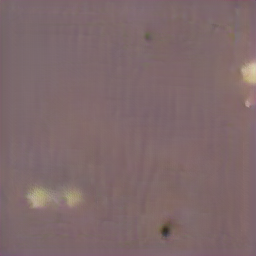

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt
using only prior


AttributeError: ignored

In [ ]:
#@title Actually do the run!
for use_prior in priors:
  tv_loss = TVLoss() 
  mse_weight = args.init_weight

  model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
  perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)
  prior = load_diffusion_model("model.pth", 'cuda:0')

  if use_prior == "without":
    print("using only vqgan + clip")
    append = "_without_prior"

  elif use_prior == "with":
    print("using only prior")
    append = "_with_prior"

  elif use_prior == "both":
    print(f"using both with weight {prior_influence}")
    append = "_with_both"


  cut_size = perceptor.visual.input_resolution

  if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
      e_dim = 256
      n_toks = model.quantize.n_embed
      z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
      z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
  else:
      e_dim = model.quantize.e_dim
      n_toks = model.quantize.n_e
      z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
      z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]


  make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

  f = 2**(model.decoder.num_resolutions - 1)
  toksX, toksY = args.size[0] // f, args.size[1] // f

  if args.seed is not None:
      torch.manual_seed(args.seed)

  if args.init_image:
      pil_image = Image.open(args.init_image).convert('RGB')
      pil_image = pil_image.resize((toksX * 16, toksY * 16), Image.LANCZOS)
      pil_image = TF.to_tensor(pil_image)
      if args.use_noise:
        pil_image = pil_image + args.use_noise * torch.randn_like(pil_image) 
      z, *_ = model.encode(pil_image.to(device).unsqueeze(0) * 2 - 1)

  else:
      
      one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()

      if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
          z = one_hot @ model.quantize.embed.weight
      else:
          z = one_hot @ model.quantize.embedding.weight
      z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)

  if args.mse_withzeros and not args.init_image:
    z_orig = torch.zeros_like(z)
  else:
    z_orig = z.clone()

  z.requires_grad = True

  opt = optim.Adam([z], lr=args.step_size, weight_decay=0.00000000)

  normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

  pMs = []

  if args.noise_prompt_weights and args.noise_prompt_seeds:
    for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
      gen = torch.Generator().manual_seed(seed)
      embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
      pMs.append(Prompt(embed, weight).to(device))

  for prompt in args.prompts:
      txt, weight, stop = parse_prompt(prompt)
      embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
      if use_prior == "with":
        text_embed = embed
        pred_embed_1 = prior.p_sample_loop((1,512), text_cond=dict(text_embed=embed))
        pred_embed_2 = prior.p_sample_loop((1,512), text_cond=dict(text_embed=embed))
        embed = select_best(text_embed, pred_embed_1, pred_embed_2)
      elif use_prior == "both":
        text_embed = embed
        pred_embed_1 = prior.p_sample_loop((1,512), text_cond=dict(text_embed=embed))
        pred_embed_2 = prior.p_sample_loop((1,512), text_cond=dict(text_embed=embed))
        pred_embed = select_best(text_embed, pred_embed_1, pred_embed_2)
        weighted_pred = prior_influence*pred_embed
        weighted_text = (1-prior_influence)*embed
        embed = weighted_pred+weighted_text

      pMs.append(Prompt(embed, weight, stop).to(device))


  def synth(z, quantize=True):
      if args.constraint_regions:
        z = replace_grad(z, z * z_mask)

      if quantize:
        if args.vqgan_checkpoint == 'vqgan_openimages_f16_8192.ckpt':
          z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
        else:
          z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)

      else:
        z_q = z.model

      return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

  @torch.no_grad()
  def checkin(i, losses):
      losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
      tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
      out = synth(z, True)

      TF.to_pil_image(out[0].cpu()).save('progress' + append + '.png')   
      display.display(display.Image('progress' + append + '.png')) 


  def ascend_txt():
      global mse_weight

      out = synth(z)

      if args.record_generation:
        with torch.no_grad():
          global vid_index
          out_a = synth(z, True)
          TF.to_pil_image(out_a[0].cpu()).save(f'/content/vids/{vid_index}.png')
          vid_index += 1

      cutouts = make_cutouts(out)

      iii = perceptor.encode_image(normalize(cutouts)).float()

      result = []

      if args.init_weight:
          
          global z_orig
          
          result.append(F.mse_loss(z, z_orig) * mse_weight / 2)
          # result.append(F.mse_loss(z, z_orig) * ((1/torch.tensor((i)*2 + 1))*mse_weight) / 2)

          with torch.no_grad():
            if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate*args.mse_epoches:

              if mse_weight - mse_decay > 0 and mse_weight - mse_decay >= mse_decay:
                mse_weight = mse_weight - mse_decay
                print(f"updated mse weight: {mse_weight}")
              else:
                mse_weight = 0
                print(f"updated mse weight: {mse_weight}")

      for prompt in pMs:
          result.append(prompt(iii))

      return result

  vid_index = 0
  def train(i):
      
      opt.zero_grad()
      lossAll = ascend_txt()

      if i % args.display_freq == 0:
          checkin(i, lossAll)
      
      loss = sum(lossAll)

      loss.backward()
      opt.step()

  i = 0
  try:
      with tqdm() as pbar:
          while True and i != args.max_itter:

              train(i)

              if i > 0 and i%args.mse_decay_rate==0 and i <= args.mse_decay_rate * args.mse_epoches:
                
                opt = optim.Adam([z], lr=args.step_size, weight_decay=0.00000000)

              i += 1
              pbar.update()

  except KeyboardInterrupt:
      pass

im1 = Image.open("progress_without_prior.png")
im2 = Image.open("progress_with_both.png")
im3 = Image.open("progress_with_prior.png")


parameter_text = ''
for k,v in arg_summary_dict.items():
  parameter_text += f"{k} : {v}\n"
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(12, 9))
fig.patch.set_facecolor('white')

ax[0].title.set_text('Without prior')
ax[0].axis('off')
ax[0].imshow(im1)

ax[1].title.set_text('Combined')
ax[1].axis('off')
ax[1].imshow(im2)

ax[2].title.set_text('With prior')
ax[2].axis('off')
ax[2].imshow(im3)

fig.suptitle(parameter_text)
print("Just copy the image (right click and copy image) and paste it into the #dalle2-results channel in the discord!")